In [159]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [160]:
def _sample_dag(dag_simulator, n_variables, dag_density, seed=None):
    """
    Samples a DAG from a specified distribution
    """
    from sparse_shift.datasets import (
        erdos_renyi_dag,
        barabasi_albert_dag,
    )
    from sparse_shift.utils import dag2cpdag, cpdag2dags

    if dag_simulator == "er":
        dag = erdos_renyi_dag(n_variables, dag_density, seed=seed)
    elif dag_simulator == "ba":
        dag = barabasi_albert_dag(n_variables, dag_density, seed=seed)
    else:
        raise ValueError(f"DAG simulator {dag_simulator} not valid optoion")

    if len(cpdag2dags(dag2cpdag(dag))) == 1:
        # Don't sample already solved MECs
        np.random.seed(seed)
        new_seed = int(1000*np.random.uniform())
        dag = _sample_dag(dag_simulator, n_variables, dag_density, new_seed)

    return dag

## Convergence with environments

In [162]:
from sparse_shift.utils import dag2cpdag, cpdag2dags
from sparse_shift.metrics import dag_precision, dag_recall, average_precision_score

EXPERIMENT = 'environment_convergence'

df = pd.read_csv(f'./results/{EXPERIMENT}_results.csv', sep=', ', engine='python')

# fix bug in computation for soft method on 1 environment
metrics = ['True orientation rate', 'False orientation rate', 'Number of possible DAGs']

update_df = df.loc[
        (df['Number of environments'] == 1) & (df['Method'] == 'Min changes (oracle)')
].set_index(['Rep', 'params_index', 'Number of environments'])

df.set_index(['Rep', 'params_index', 'Number of environments'], inplace=True)

df.update(
    update_df[metrics]
)
df.reset_index(inplace=True)

# new metric
df['Fraction of possible DAGs'] = (df['Number of possible DAGs'] - 1)  / (df['MEC size'] - 1)

df['Precision'] = 1
tpfp = df['True orientation rate'] + df['False orientation rate']
df.loc[tpfp > 0, 'Precision'] = df.loc[tpfp > 0, 'True orientation rate'] / tpfp[tpfp > 0]

df['Recall'] = df['True orientation rate']

df['Avg precision'] = np.nan

method_dict = {
    'Min changes (kci)': 'mch_kci',
    'Min changes (linear)': 'mch_lin',
}

custom_score_mat = []
for params in df['params_index'].unique():
    for rep in df['Rep'].unique():
        rep_idx = (df['Rep'] == rep) & (df['params_index'] == params)
        sub_df = df.loc[rep_idx]
        dag_simulator = sub_df['dag_simulator'].iloc[0]
        n_variables = int(sub_df['n_variables'].iloc[0])
        density = sub_df['dag_density'].iloc[0]
        true_dag = _sample_dag(dag_simulator, n_variables, density, seed=int(rep))
        dags = np.asarray(cpdag2dags(dag2cpdag(true_dag)))
                          
        alpha = 0.05 / n_variables

        for method in ['Min changes (kci)', 'Min changes (linear)']:
            pvalues = np.load(f'./results/pvalue_mats/{EXPERIMENT}_{method_dict[method]}_pvalues_params={params}_rep={rep}.npy')
            
            for n_env in df['Number of environments'].unique():
                env_idx = (df['Number of environments'] == n_env) & (df['Method'] == method)
                
                # Soft scores
                scores = np.sum(1 - pvalues[:, :, :n_env, :n_env], axis=(1,2,3))
                min_idx = np.where(scores == np.min(scores))[0]
                cpdag = (np.sum(dags[min_idx], axis=0) > 0).astype(int)
            
                precision = dag_precision(true_dag, cpdag)
                recall = dag_recall(true_dag, cpdag)

                df.loc[
                    rep_idx &
                    env_idx &
                    (df['Soft'] == True),
                    ['Precision', 'Recall']
                ] = [precision, recall]
                
                # Hard scores
                scores = np.sum(pvalues[:, :, :n_env, :n_env] <= alpha, axis=(1,2,3))
                min_idx = np.where(scores == np.min(scores))[0]
                cpdag = (np.sum(dags[min_idx], axis=0) > 0).astype(int)
            
                precision = dag_precision(true_dag, cpdag)
                recall = dag_recall(true_dag, cpdag)
                ap_score = average_precision_score(true_dag, pvalues[:, :, :n_env, :n_env])

                df.loc[
                    rep_idx &
                    env_idx &
                    (df['Soft'] == False),
                    ['Precision', 'Recall', 'Avg precision']
                ] = [precision, recall, ap_score]

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/Documents/MPI/sparse_shift/sparse_shift/datasets/dags.py:75: UserWarning: Number of neighbors 2.0 will be rounded
  warnings.warn(f'Number of neighbors {m:.1f} will be rounded')
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/D

In [163]:
plot_df = df.melt(
    id_vars=[
        'params_index', 'n_variables', 'n_total_environments', 'sparsity',
        'sample_size', 'dag_density', 'reps', 'data_simulator', 'dag_simulator',
        'Method', 'Number of environments', 'Rep', 'MEC size', 'Soft'],
    # value_vars=['True orientation rate', 'False orientation rate', 'Avg precision'], # 'Fraction of possible DAGs'], 
    value_vars=['Precision', 'Recall', 'Avg precision'],
    var_name='Metric',
    value_name='Average fraction',
)

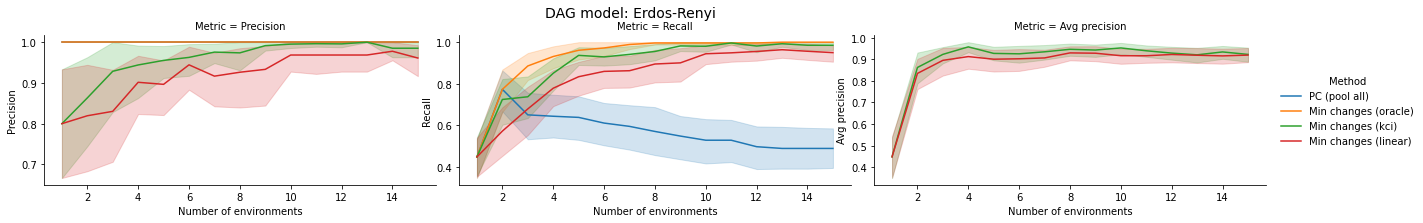

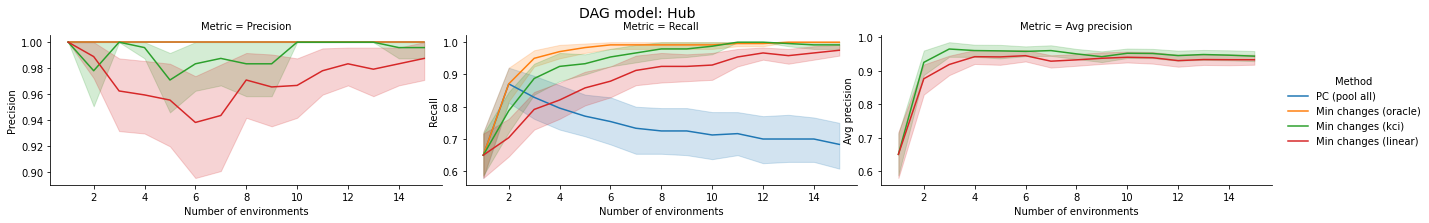

In [164]:
for ds in df['dag_simulator'].unique():
    g = sns.relplot(
        data=plot_df[
            (plot_df['sample_size'] == plot_df['sample_size'].max()) &
            (plot_df['dag_simulator'] == ds) &
            (plot_df['Soft'] == False)
        ],
        x='Number of environments',
        y='Average fraction',
        hue='Method',
        # row='sparsity',
        col='Metric',
        # ci=None,
        kind='line',
        height=3,
        aspect=2, # 3,
        # legend='Full',
        facet_kws={'sharey': False, 'sharex': True},
    )
    
    col_vals = g.data[g._col_var].unique()
    for c, col_val in enumerate(col_vals):
        g.axes[0, c].set_ylabel(col_val, visible=True)
    
#     row_vals = g.data[g._row_var].unique()
#     for r, row_val in enumerate(row_vals):
#         for c, col_val in enumerate(col_vals):
#             g.axes[r, c].set_title(f'{g._row_var} = {row_val}')
#             g.axes[r, c].set_ylabel(col_val, visible=True)
    
    title_dict = dict({"er": "Erdos-Renyi", "ba": "Hub"})
    g.fig.suptitle(f'DAG model: {title_dict[ds]}', fontsize=14, y=1.02, x=0.45)
    plt.subplots_adjust(wspace=0.06)
    plt.show()

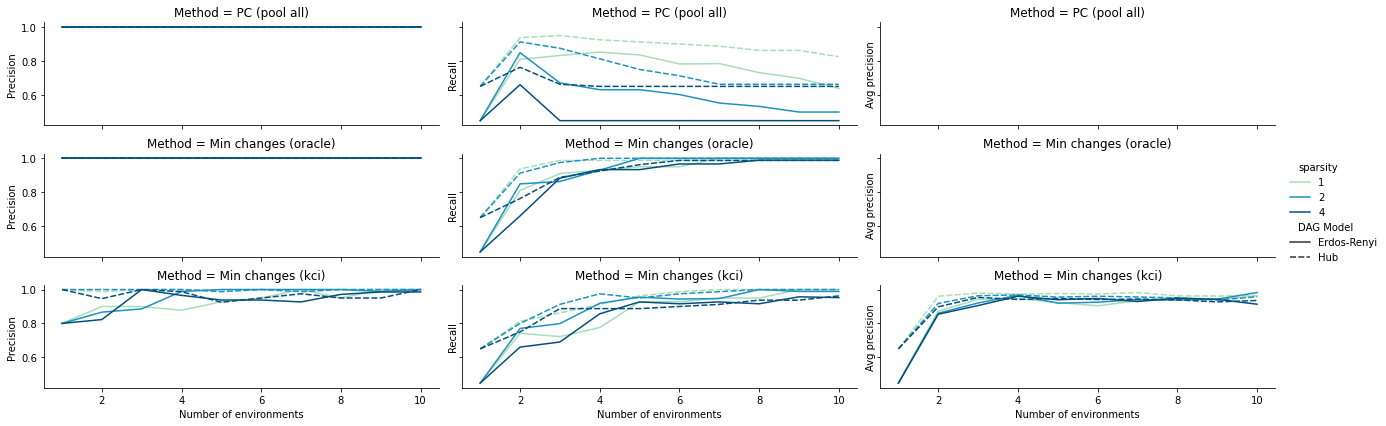

In [165]:
# for ds in df['dag_simulator'].unique():
g = sns.relplot(
    data=plot_df[
        # (plot_df['dag_simulator'] == ds) &
        (plot_df['sample_size'] == plot_df['sample_size'].max()) &
        (plot_df['Method'].isin(['PC (pool all)', 'Min changes (oracle)', 'Min changes (kci)'])) &
        (plot_df['Soft'] == False) & 
        (plot_df['Number of environments'] <= 10)
    ].rename(
        {'dag_simulator': 'DAG Model'}, axis=1
    ).replace(
        {'er': 'Erdos-Renyi', 'ba': 'Hub'}
    ),
    x='Number of environments',
    y='Average fraction',
    row='Method',
    hue='sparsity',
    col='Metric',
    style='DAG Model',
    ci=None,
    kind='line',
    height=2, aspect=3,
    palette=['#a8ddb5', '#1d91c0', '#034e7b'],
    # legend='Full',
)

row_vals = g.data[g._row_var].unique()
col_vals = g.data[g._col_var].unique()
for r, row_val in enumerate(row_vals):
    for c, col_val in enumerate(col_vals):
        g.axes[r, c].set_title(f'{g._row_var} = {row_val}')
        g.axes[r, c].set_ylabel(col_val, visible=True)

plt.subplots_adjust(wspace=0.06)
plt.show()

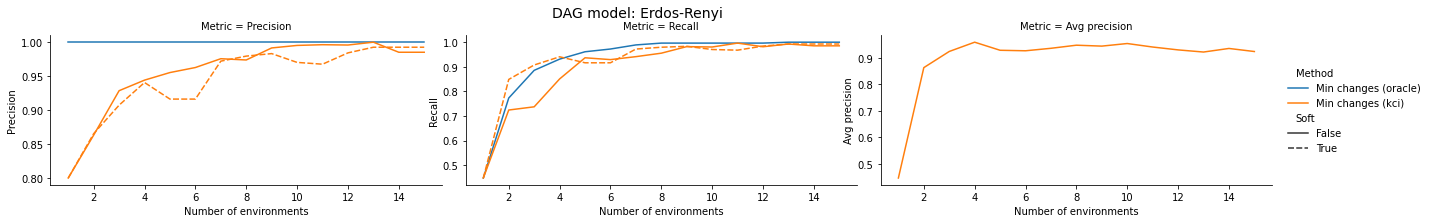

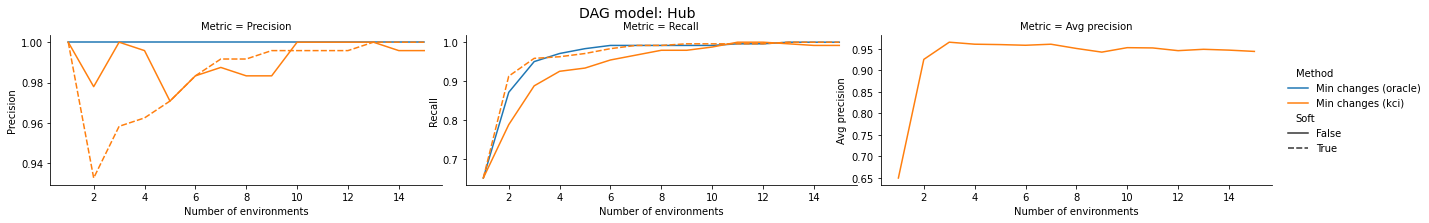

In [166]:
for ds in df['dag_simulator'].unique():
    g = sns.relplot(
        data=plot_df[
            (plot_df['sample_size'] == plot_df['sample_size'].max()) &
            (plot_df['Method'].isin(['Min changes (oracle)', 'Min changes (kci)'])) &
            (plot_df['dag_simulator'] == ds)
            # (plot_df['Soft'] == False)
        ],
        x='Number of environments',
        y='Average fraction',
        hue='Method',
        # row='sparsity',
        col='Metric',
        style='Soft',
        ci=None,
        kind='line',
        height=3,
        aspect=2, # 3,
        # legend='Full',
        facet_kws={'sharey': False, 'sharex': True},
    )
    
    col_vals = g.data[g._col_var].unique()
    for c, col_val in enumerate(col_vals):
        g.axes[0, c].set_ylabel(col_val, visible=True)
    
#     row_vals = g.data[g._row_var].unique()
#     for r, row_val in enumerate(row_vals):
#         for c, col_val in enumerate(col_vals):
#             g.axes[r, c].set_title(f'{g._row_var} = {row_val}')
#             g.axes[r, c].set_ylabel(col_val, visible=True)
    
    title_dict = dict({"er": "Erdos-Renyi", "ba": "Hub"})
    g.fig.suptitle(f'DAG model: {title_dict[ds]}', fontsize=14, y=1.02, x=0.45)
    plt.subplots_adjust(wspace=0.06)
    plt.show()

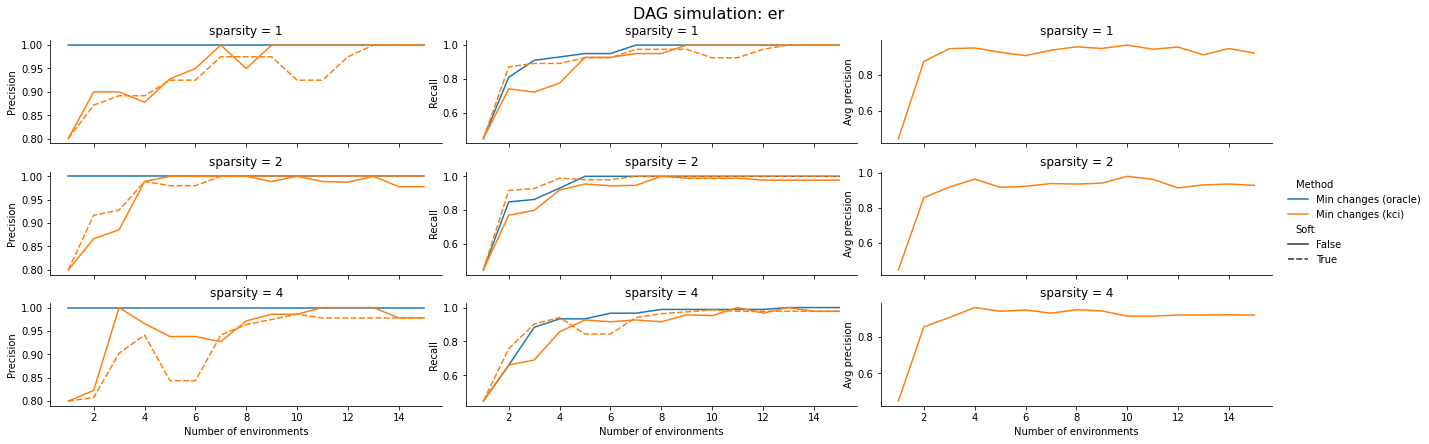

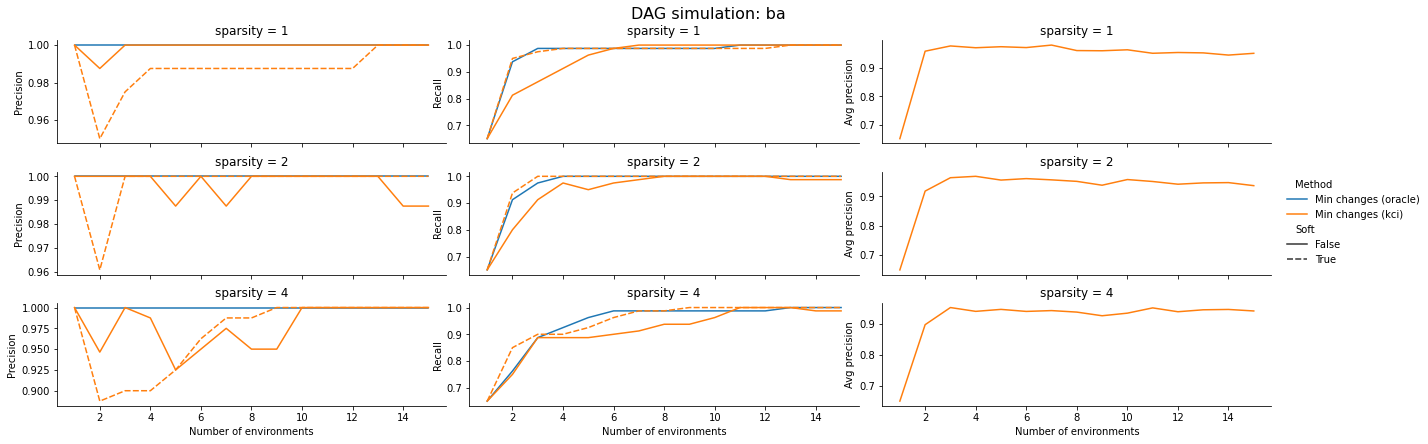

In [167]:
for ds in df['dag_simulator'].unique():
    g = sns.relplot(
        data=plot_df[
            (plot_df['dag_simulator'] == ds)
            & (plot_df['Method'].isin(['Min changes (oracle)', 'Min changes (kci)']))
            # & (plot_df['Soft'] == False)
        ],
        x='Number of environments',
        y='Average fraction',
        hue='Method',
        row='sparsity',
        col='Metric',
        ci=None,
        style='Soft',
        kind='line',
        height=2, aspect=3,
        facet_kws={'sharey': False, 'sharex': True},
    )

    row_vals = g.data[g._row_var].unique()
    col_vals = g.data[g._col_var].unique()
    for r, row_val in enumerate(row_vals):
        for c, col_val in enumerate(col_vals):
            g.axes[r, c].set_title(f'{g._row_var} = {row_val}')
            g.axes[r, c].set_ylabel(col_val, visible=True)
    
    g.fig.suptitle(f'DAG simulation: {ds}', fontsize=16, y=1.02)
    plt.subplots_adjust(wspace=0.06)
    plt.show()

## Soft score vs sample size

In [169]:
def preprocess_df(df):
    # fix bug in computation for soft method on 1 environment
    metrics = ['True orientation rate', 'False orientation rate', 'Number of possible DAGs']

    update_df = df.loc[
            (df['Number of environments'] == 1) & (df['Method'] == 'Min changes (oracle)')
    ].set_index(['Rep', 'params_index', 'Number of environments'])

    df.set_index(['Rep', 'params_index', 'Number of environments'], inplace=True)

    df.update(
        update_df[metrics]
    )
    df.reset_index(inplace=True)
    
    from sparse_shift.utils import dag2cpdag, cpdag2dags
    from sparse_shift.metrics import dag_precision, dag_recall, average_precision_score

    method_dict = {
        'Min changes (kci)': 'mch_kci',
        'Min changes (linear)': 'mch_lin',
    }

    df['Precision'] = 1
    tpfp = df['True orientation rate'] + df['False orientation rate']
    df.loc[tpfp > 0, 'Precision'] = df.loc[tpfp > 0, 'True orientation rate'] / tpfp[tpfp > 0]

    df['Recall'] = df['True orientation rate']

    df['Avg precision'] = np.nan

    custom_score_mat = []
    for params in df['params_index'].unique():
        for rep in df['Rep'].unique():
            rep_idx = (df['Rep'] == rep) & (df['params_index'] == params)
            sub_df = df.loc[rep_idx]
            dag_simulator = sub_df['dag_simulator'].iloc[0]
            n_variables = int(sub_df['n_variables'].iloc[0])
            density = sub_df['dag_density'].iloc[0]
            true_dag = _sample_dag(dag_simulator, n_variables, density, seed=int(rep))
            dags = np.asarray(cpdag2dags(dag2cpdag(true_dag)))

            alpha = 0.05 / n_variables

            for method in ['Min changes (kci)', 'Min changes (linear)']:
                pvalues = np.load(f'./results/pvalue_mats/{EXPERIMENT}_{method_dict[method]}_pvalues_params={params}_rep={rep}.npy')

                for n_env in df['Number of environments'].unique():
                    env_idx = (df['Number of environments'] == n_env) & (df['Method'] == method)

                    # Soft scores
                    scores = np.sum(1 - pvalues[:, :, :n_env, :n_env], axis=(1,2,3))
                    min_idx = np.where(scores == np.min(scores))[0]
                    cpdag = (np.sum(dags[min_idx], axis=0) > 0).astype(int)

                    precision = dag_precision(true_dag, cpdag)
                    recall = dag_recall(true_dag, cpdag)

                    df.loc[
                        rep_idx &
                        env_idx &
                        (df['Soft'] == True),
                        ['Precision', 'Recall']
                    ] = [precision, recall]

                    # Hard scores
                    scores = np.sum(pvalues[:, :, :n_env, :n_env] <= alpha, axis=(1,2,3))
                    min_idx = np.where(scores == np.min(scores))[0]
                    cpdag = (np.sum(dags[min_idx], axis=0) > 0).astype(int)

                    precision = dag_precision(true_dag, cpdag)
                    recall = dag_recall(true_dag, cpdag)
                    ap_score = average_precision_score(true_dag, pvalues[:, :, :n_env, :n_env])

                    df.loc[
                        rep_idx &
                        env_idx &
                        (df['Soft'] == False),
                        ['Precision', 'Recall', 'Avg precision']
                    ] = [precision, recall, ap_score]
                    
    return df

In [170]:
EXPERIMENT = 'soft_samples'
df_soft_samples = pd.read_csv(f'./results/{EXPERIMENT}_results.csv', sep=', ', engine='python')
df_soft_samples = preprocess_df(df_soft_samples)

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  

In [178]:
plot_df = df_soft_samples.melt(
    id_vars=[
        'params_index', 'n_variables', 'n_total_environments', 'sparsity',
        'sample_size', 'dag_density', 'reps', 'data_simulator', 'dag_simulator',
        'Method', 'Number of environments', 'Rep', 'MEC size', 'Soft'],
    # value_vars=['True orientation rate', 'False orientation rate', 'Avg precision'], # 'Fraction of possible DAGs'], 
    value_vars=['Precision', 'Recall'], #'Avg precision'],
    var_name='Metric',
    value_name='Average fraction',
)

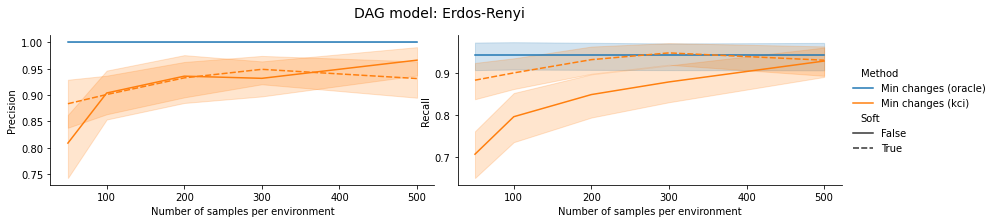

In [186]:
for ds in plot_df['dag_simulator'].unique():
    g = sns.relplot(
        data=plot_df[
            (plot_df['Number of environments'] == 5) &#plot_df['Number of environments'].max()) &
            (plot_df['Method'].isin(['Min changes (oracle)', 'Min changes (kci)'])) &
            (plot_df['dag_simulator'] == ds)
            # (plot_df['Soft'] == False)
        ].rename(
            {"sample_size": "Number of samples per environment"}, axis=1
        ),
        x='Number of samples per environment',
        y='Average fraction',
        hue='Method',
        # row='sparsity',
        col='Metric',
        style='Soft',
        # ci=None,
        kind='line',
        height=3,
        aspect=2, # 3,
        # legend='Full',
        facet_kws={'sharey': False, 'sharex': True},
    )
    
    col_vals = g.data[g._col_var].unique()
    for c, col_val in enumerate(col_vals):
        g.axes[0, c].set_ylabel(col_val, visible=True)
        g.axes[0, c].set_title('')
    
    title_dict = dict({"er": "Erdos-Renyi", "ba": "Hub"})
    g.fig.suptitle(f'DAG model: {title_dict[ds]}', fontsize=14, y=1.02, x=0.45)
    plt.subplots_adjust(wspace=0.06)
    plt.show()